In [1]:
import numpy as np
import pandas as pd
import sklearn as ktl
import pickle
import matplotlib.pylab as plt
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

import statsmodels.formula.api as smf

from linearmodels.panel import PanelOLS


In [2]:
bol = pd.read_csv("/Users/hendrixperalta/Desktop/bolivia/data/GeoDS4Bolivia.csv")
bol = bol.rename(columns={"asdf_id":"id"})
#list(bol.columns)

In [3]:

#list(bol.columns)
offset = 1000  

# EGDP
sat = pd.read_csv("data/egdp/satelite_data.csv")
sat["EGDPpc2012"] = (sat["egdp2012"]*1000000/ bol["tr400_pop2012"])
sat["lnEGDPpc2012"] = np.log(sat["EGDPpc2012"])

# Merge
df = pd.merge(bol, sat, on="id", how="outer")

# Land cover
df["lnagr_land2012"] = np.log(df["agr_land2012"] + offset)
df["lnurb_land2012"] = np.log(df["urb_land2012"] + offset)

df["total_land2012"] = df["agr_land2012"] + df["urb_land2012"]
df["perUrb_land"] = df["urb_land2012"] / df["total_land2012"]
df["ln_perUrb_land"] = np.log(df["perUrb_land"].fillna(0) + offset)

# Population
df["ln_tr400_pop2012"] = np.log(df["tr400_pop2012"])

# PM2.5
df["ln_pm25_2012"] = np.log(df["pm25_2012"])

# Surface temperature
df["ln_land_temp2012"] = np.log(df["land_temp2012"])

# **Data exploration**

In [4]:
short_df = df[["imds","ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 
               'ln_land_temp2012', "lnagr_land2012", "lnurb_land2012", "ln_perUrb_land"]]
short_df.isna().sum()

imds                0
ln_t400NTLpc2012    0
ln_tr400_pop2012    0
lnEGDPpc2012        0
ln_pm25_2012        0
ln_land_temp2012    0
lnagr_land2012      0
lnurb_land2012      0
ln_perUrb_land      0
dtype: int64

In [5]:
print(df[["agr_land2012", "urb_land2012"]])

     agr_land2012  urb_land2012
0        0.000000      0.000000
1        0.000000      0.000000
2        0.000000      0.000000
3       50.276154    195.118281
4        0.000000      0.000000
..            ...           ...
334      0.000000      1.254882
335      8.085184      0.000000
336     29.080455      0.000000
337      0.000000    320.778602
338     47.023029     16.002446

[339 rows x 2 columns]


In [6]:
short_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   imds              339 non-null    float64
 1   ln_t400NTLpc2012  339 non-null    float64
 2   ln_tr400_pop2012  339 non-null    float64
 3   lnEGDPpc2012      339 non-null    float64
 4   ln_pm25_2012      339 non-null    float64
 5   ln_land_temp2012  339 non-null    float64
 6   lnagr_land2012    339 non-null    float64
 7   lnurb_land2012    339 non-null    float64
 8   ln_perUrb_land    339 non-null    float64
dtypes: float64(9)
memory usage: 24.0 KB


In [7]:
short_df.describe()

,imds,ln_t400NTLpc2012,ln_tr400_pop2012,lnEGDPpc2012,ln_pm25_2012,ln_land_temp2012,lnagr_land2012,lnurb_land2012,ln_perUrb_land
count,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000
mean,51.050442,13.033028,9.335445,8.395351,3.118672,5.696477,6.966940,7.004299,6.908019
std,6.771824,1.671621,1.145385,1.238107,0.287753,0.011639,0.179915,0.394750,0.000346
min,35.700001,0.856095,6.251161,4.706205,2.111170,5.659918,6.907755,6.907755,6.907755
25%,47.000000,12.050438,8.686743,7.528378,2.893310,5.689875,6.907755,6.907755,6.907755
50%,50.500000,13.118243,9.294614,8.238783,3.087198,5.698119,6.913097,6.907755,6.907755
75%,54.850001,14.268402,9.903637,9.158287,3.357998,5.705713,6.935352,6.928602,6.908288
max,80.199997,17.071051,14.171911,11.689671,3.649784,5.720777,8.374316,10.265991,6.908755


In [8]:
mod = smf.ols("imds ~  ln_t400NTLpc2012 + ln_tr400_pop2012 + lnEGDPpc2012 + ln_pm25_2012 ", 
              data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   imds   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     52.92
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           1.65e-34
Time:                        15:09:35   Log-Likelihood:                -1045.7
No. Observations:                 339   AIC:                             2101.
Df Residuals:                     334   BIC:                             2121.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.8725      4.370  

In [9]:
missing_labels = df.columns[df.isna().any()]
missing_labels

Index(['sdg1_1_eepr', 'sdg2_4_pual', 'sdg2_4_td', 'sdg5_5_gpop', 'sdg8_4_rem',
       'sdg9_5_eutf', 'sdg10_2_iec', 'sdg1_1_dtl_abs', 'sdg2_4_apu_abs',
       'sdg2_4_tm_abs', 'sdg3_1_udhf_ab', 'sdg8_4_rem_abs', 'sdg9_5_eutf_abs',
       'ln_NTLpc2012', 'ln_NTLpc2013', 'ln_NTLpc2014', 'ln_NTLpc2015',
       'ln_NTLpc2016', 'ln_NTLpc2017', 'ln_NTLpc2018', 'ln_NTLpc2019',
       'ln_NTLpc2020', 'perUrb_land'],
      dtype='object')

In [10]:
#plt.style.available

[Text(0.5, 1.0, 'PM25')]

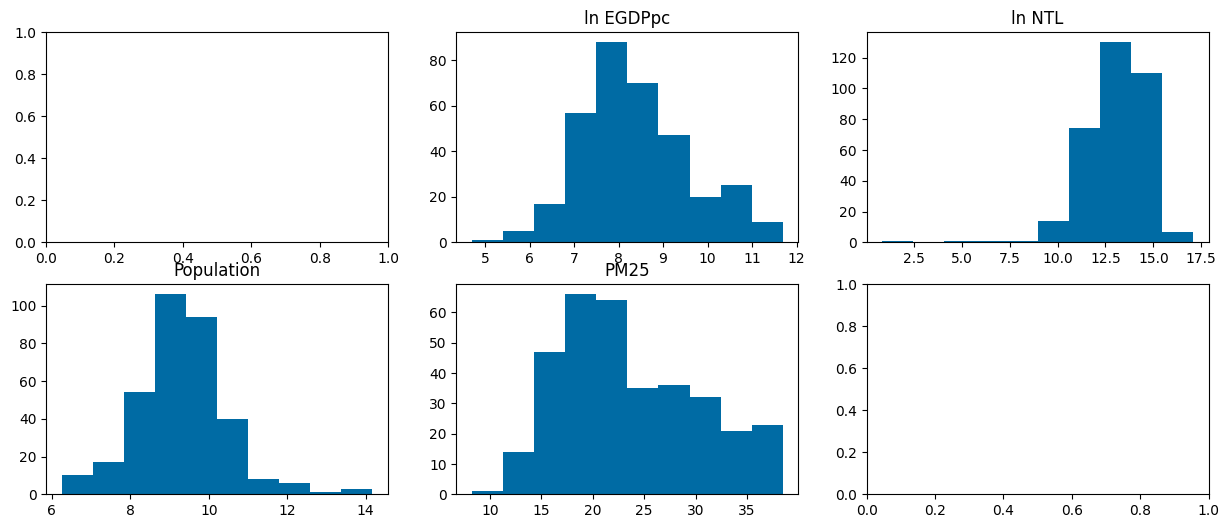

In [11]:
plt.style.use("tableau-colorblind10")

fig, ((ax0, ax1, ax2),(ax3, ax4, ax5)) = plt.subplots(nrows=2,
                                                     ncols=3,
                                                     figsize=(15,6)
                                                     )
#ax0.hist(df["perUrb_land"])
#ax0.set(title="Percentage of Urban Land")

ax1.hist(df["lnEGDPpc2012"])
ax1.set(title="ln EGDPpc")

ax2.hist(df["ln_t400NTLpc2012"])
ax2.set(title="ln NTL")

ax3.hist(df["ln_tr400_pop2012"])
ax3.set(title= "Population")

ax4.hist(df["pm25_2012"])
ax4.set(title= "PM25")

#ax5.hist(df["land_temp2012"])
#ax5.set(title= "Land Surface Temperature");


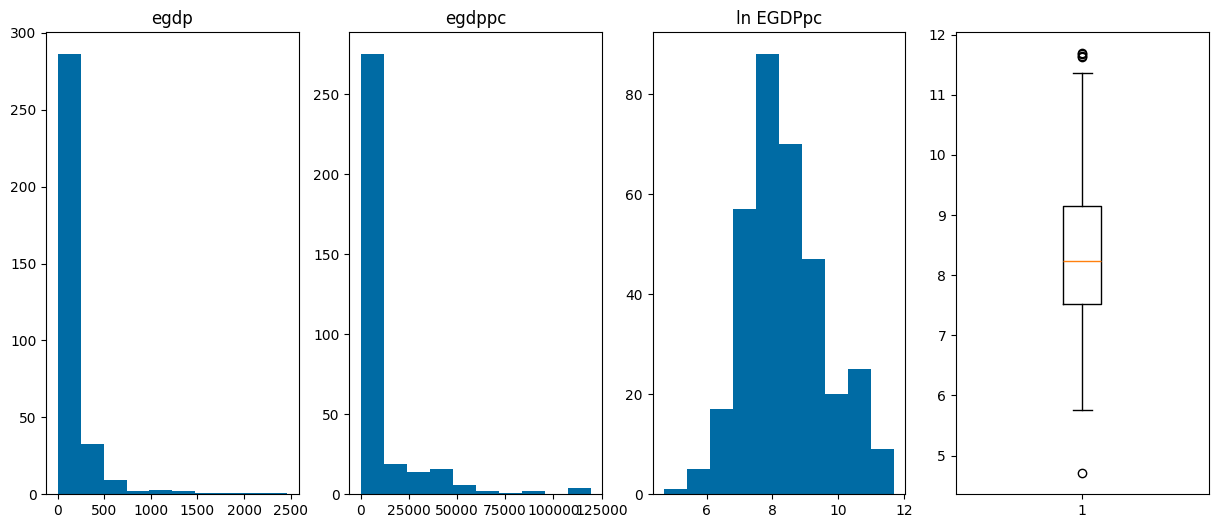

In [12]:
plt.style.use("tableau-colorblind10")

fig, (ax0, ax1, ax2, ax4) = plt.subplots(nrows=1,
                                 ncols=4,
                                 figsize=(15,6)
                                 )
ax0.hist(sat["egdp2012"])
ax0.set(title="egdp")

ax1.hist(df["EGDPpc2012"])
ax1.set(title= "egdppc")

ax2.hist(df["lnEGDPpc2012"])
ax2.set(title="ln EGDPpc")

ax4.boxplot(df["lnEGDPpc2012"]);


In [13]:
#plt.style.available

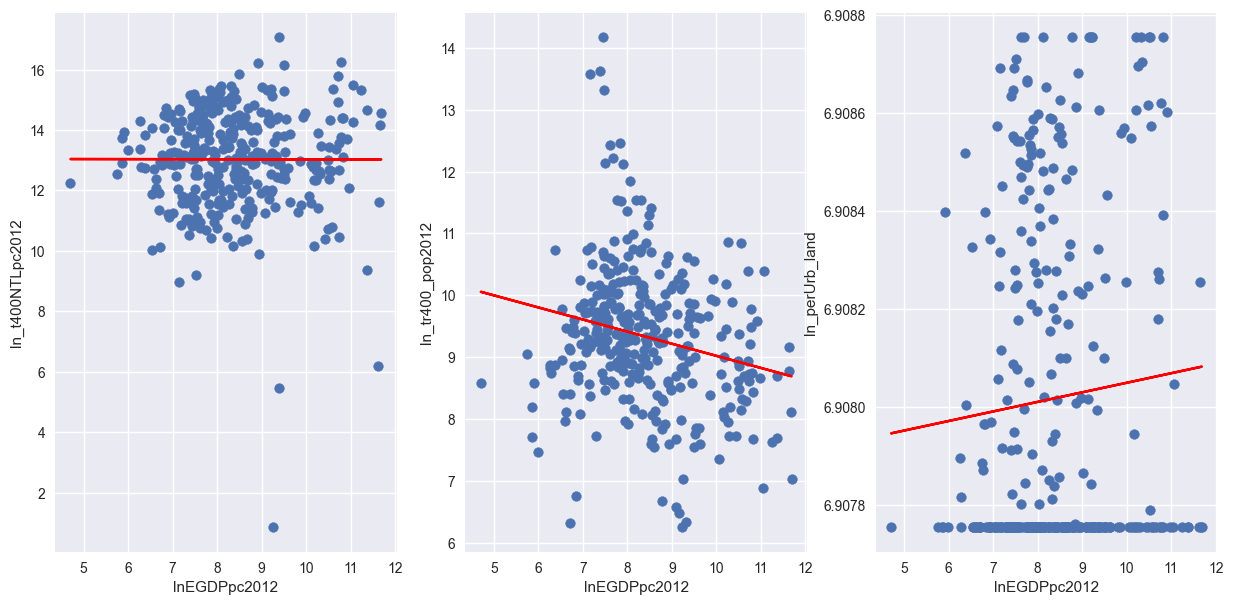

In [14]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=short_df['lnEGDPpc2012'], y=short_df["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=short_df["lnEGDPpc2012"], y=short_df['ln_tr400_pop2012'])
ax1.set(xlabel="lnEGDPpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax2
ax2.scatter(x=short_df["lnEGDPpc2012"], y=short_df['ln_perUrb_land'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="ln_perUrb_land")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_perUrb_land'], 1)
p = np.poly1d(z)
ax2.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")



In [15]:
egdp_ntl = short_df["lnEGDPpc2012"].corr(short_df['ln_t400NTLpc2012'])
egdp_pop = short_df["lnEGDPpc2012"].corr(short_df['ln_tr400_pop2012'])
egdp_urb = short_df["lnEGDPpc2012"].corr(short_df['ln_perUrb_land'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

Correlation of egdp and ntl: -0.0013160348349785576
Correlation of egdp and pop: -0.21141855279870278
Correlation of egdp and Urban land %: 0.06980531985494491


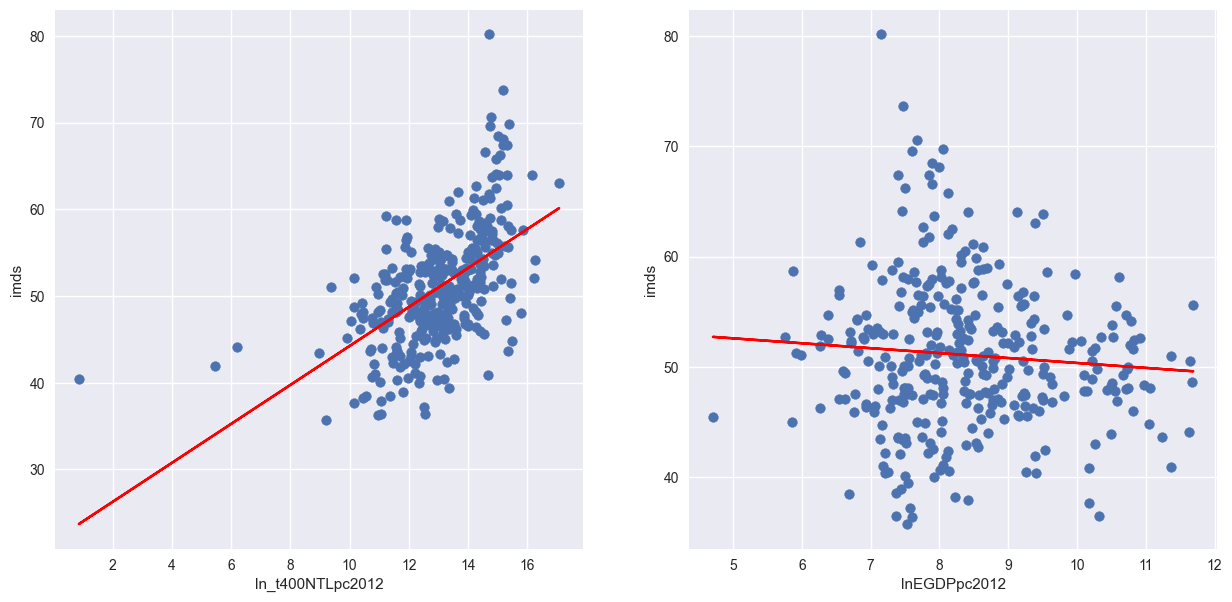

In [16]:

fig, (ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=2,
                                    figsize=(15,7))

#----- ax1
ax1.scatter(x=short_df["ln_t400NTLpc2012"], y=short_df['imds'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="imds")

# add trendline
z = np.polyfit(short_df["ln_t400NTLpc2012"], short_df['imds'], 1)
p = np.poly1d(z)
ax1.plot(short_df["ln_t400NTLpc2012"],p(short_df["ln_t400NTLpc2012"]), "r-")

#----- ax2
ax2.scatter(x=short_df["lnEGDPpc2012"], y=short_df['imds'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="imds");

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['imds'], 1)
p = np.poly1d(z)
ax2.plot(short_df["lnEGDPpc2012"], p(short_df["lnEGDPpc2012"]), "r-")

In [17]:
ntl_imds = short_df["ln_t400NTLpc2012"].corr(short_df['imds'])
egdp_imds = short_df["lnEGDPpc2012"].corr(short_df['imds'])

print(f"Correlation of ntl and imds: {ntl_imds}")
print(f"Correlation of egdp and imds: {egdp_imds}")

Correlation of ntl and imds: 0.5548280194761073
Correlation of egdp and imds: -0.08182429944254284


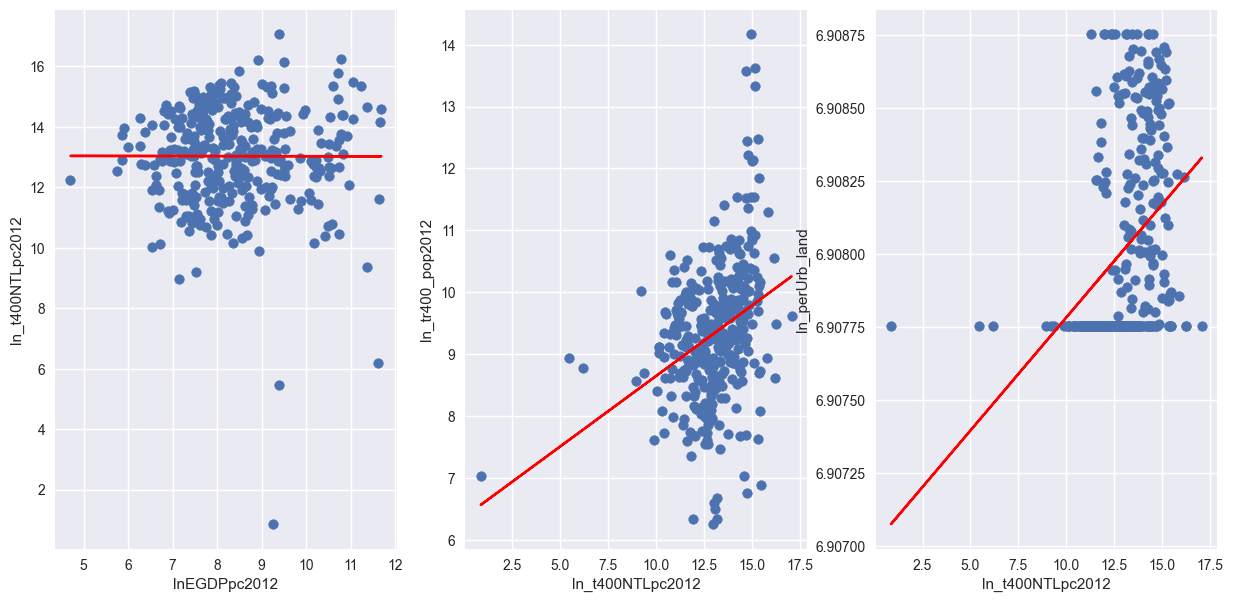

In [18]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=short_df['lnEGDPpc2012'], y=short_df["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=short_df["ln_t400NTLpc2012"], y=short_df['ln_tr400_pop2012'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(short_df["ln_t400NTLpc2012"], short_df['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(short_df["ln_t400NTLpc2012"],p(short_df["ln_t400NTLpc2012"]),"r-")

#----- ax2
ax2.scatter(x=short_df["ln_t400NTLpc2012"], y=short_df['ln_perUrb_land'])
ax2.set(xlabel="ln_t400NTLpc2012", ylabel="ln_perUrb_land")

# add trendline
z = np.polyfit(short_df["ln_t400NTLpc2012"], short_df['ln_perUrb_land'], 1)
p = np.poly1d(z)
ax2.plot(short_df["ln_t400NTLpc2012"],p(short_df["ln_t400NTLpc2012"]),"r-")



In [19]:
egdp_ntl = short_df["lnEGDPpc2012"].corr(short_df['ln_t400NTLpc2012'])
egdp_pop = short_df["ln_t400NTLpc2012"].corr(short_df['ln_tr400_pop2012'])
egdp_urb = short_df["ln_t400NTLpc2012"].corr(short_df['ln_perUrb_land'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

Correlation of egdp and ntl: -0.0013160348349785576
Correlation of egdp and pop: 0.3324972344406324
Correlation of egdp and Urban land %: 0.3744299375753733


# **Regression models**

### Linear model

In [43]:
x = df[["ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 'ln_land_temp2012', 'lnagr_land2012', 'lnurb_land2012']].fillna(0)
y = df['imds']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

model = LinearRegression()
model.fit(x_train,y_train)

# r2 
#lr = model.score(x_test, y_test)
lr = np.mean(cross_val_score(model, x, y))

# MAE
lr_mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


### Ridge  model

In [49]:

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rid_model = linear_model.Ridge()
rid_model.fit(x_train, y_train)

# r2
#ri = rid_model.score(x_test, y_test)
ri = np.mean(cross_val_score(rid_model, x, y))

# MAE
ri_mae = np.mean(cross_val_score(rid_model, x, y, scoring="neg_mean_absolute_error"))

### Random Forest Regressor model

In [54]:

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

# r2
#rf = rf_model.score(x_test, y_test)
rf = np.mean(cross_val_score(rf_model, x, y))

# MAE
rf_mae = np.mean(cross_val_score(rf_model, x, y, scoring="neg_mean_absolute_error"))

### Results 

In [55]:
print("R2 for the regressor models")
print(f" Linear model  cv ->   R2: {lr*100:.2f}%,  MAE: {lr_mae:.2f}")
print(f" Ridger model  cv ->   R2: {ri*100:.2f}%,  MAE: {ri_mae:.2f}")
print(f" RF model      cv ->   R2: {rf*100:.2f}%,  MAE: {rf_mae:.2f} ")

R2 for the regressor models
 Linear model  cv ->   R2: 35.81%,  MAE: -4.14
 Ridger model  cv ->   R2: 36.99%,  MAE: -4.09
 RF model      cv ->   R2: 48.65%,  MAE: -3.63 


# **Categorical analysis**

In [24]:
quantile_labels = ["low", 'medium-low', 'medium-high', 'high']
df["imds_quantile"] = pd.qcut(df["imds"], q=4, labels=quantile_labels)
#df["imds_quantile"]

In [37]:
x = df[["ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 'ln_land_temp2012', 'lnagr_land2012', 'lnurb_land2012']].fillna(0)
y = df['imds_quantile']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

clf = RandomForestClassifier()
#clf.get_params()
clf.fit(x_train,y_train);

y_preds = clf.predict(x_test)

#evaluate the model
#print(f" Train data score: {clf.score(x_train, y_train)*100:.2f}%")
print(f" Test data score: {clf.score(x_test, y_test)*100:.2f}%")
rf_cl = clf.score(x_test, y_test)

 Test data score: 50.00%


In [26]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

        high       0.80      0.67      0.73        18
         low       0.43      0.60      0.50        15
 medium-high       0.38      0.28      0.32        18
  medium-low       0.42      0.47      0.44        17

    accuracy                           0.50        68
   macro avg       0.51      0.50      0.50        68
weighted avg       0.51      0.50      0.50        68



In [27]:
print(confusion_matrix(y_test, y_preds))

[[12  2  4  0]
 [ 0  9  1  5]
 [ 2  5  5  6]
 [ 1  5  3  8]]


In [28]:
accuracy_score(y_test, y_preds)

0.5

In [29]:
# improve model

np.random.seed(42)
for i in range(10, 100, 10):
    print(f"Trying model with {i} stimators")
    clf = RandomForestClassifier(n_estimators=i).fit(x_train, y_train)
    print(f"Model acurracy is {clf.score(x_test, y_test)*100:.2f}%")

Trying model with 10 stimators
Model acurracy is 47.06%
Trying model with 20 stimators
Model acurracy is 48.53%
Trying model with 30 stimators
Model acurracy is 44.12%
Trying model with 40 stimators
Model acurracy is 51.47%
Trying model with 50 stimators
Model acurracy is 48.53%
Trying model with 60 stimators
Model acurracy is 42.65%
Trying model with 70 stimators
Model acurracy is 42.65%
Trying model with 80 stimators
Model acurracy is 45.59%
Trying model with 90 stimators
Model acurracy is 47.06%


In [30]:
#pickle.dump(clf, open("random_forest_model.pkl", "wb"))

#load_model = pickle.load(open("random_forest_model.pkl", "rb"))
#load_model.score(x_test, y_test)

### Linear SVC Classifier

In [31]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

sgd_cla = svm.LinearSVC(dual="auto", max_iter=10000)
sgd_cla.fit(x_train, y_train)
sgd_cl = sgd_cla.score(x_test, y_test)

### Naive Bayes Classifier

In [32]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

naive_cla = GaussianNB()
naive_cla.fit(x_train, y_train)
naive_cl = naive_cla.score(x_test, y_test)

### Results 

In [33]:
print("R2 for the classifier models")
print(f" Random Forest model: {rf_cl*100:.2f}%")
print(f" Linear SVC model: {sgd_cl*100:.2f}%")
print(f" Naive Bayes model: {naive_cl*100:.2f}%")

R2 for the classifier models
 Random Forest model: 50.00%
 Linear SVC model: 44.12%
 Naive Bayes model: 39.71%


## Iterate regression models

In [34]:
y_variables = list(bol.columns)
del y_variables[195:420]
del y_variables[10:13]
del y_variables[0:8]

In [35]:
#y_variables

### Linear Regression

In [56]:
model_results = {}

for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 'ln_land_temp2012']]
    y = filtered_df[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    model = LinearRegression()
    model.fit(x_train,y_train)

    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[y_variable] = r2

res_90 = {key: value for key, value in model_results.items() if value > 0.9}
res_80 = {key: value for key, value in model_results.items() if (value > 0.8 and value < 0.9)}
res_70 = {key: value for key, value in model_results.items() if (value > 0.7 and value < 0.8)}

res_neg = {key: value for key, value in model_results.items() if value < 0}

#    print(f"For the variable {y_variable} Mean Squared Error:", mse)
#    print("R^2 Score:", r2)


In [ ]:
res_90

In [ ]:
res_80

In [ ]:
res_70

In [ ]:
res_neg

### Random Forest Regressor

In [ ]:
model_results = {}

for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land',  "ln_pm25_2012", "ln_land_temp2012"]].fillna(0)
    y = filtered_df[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    model = RandomForestRegressor()
    model.fit(x_train,y_train)

    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[y_variable] = r2

res_90 = {key: value for key, value in model_results.items() if value > 0.9}
res_80 = {key: value for key, value in model_results.items() if (value > 0.8 and value < 0.9)}
res_70 = {key: value for key, value in model_results.items() if (value > 0.7 and value < 0.8)}

res_neg = {key: value for key, value in model_results.items() if value < 0}

#    print(f"For the variable {y_variable} Mean Squared Error:", mse)
#    print("R^2 Score:", r2)


In [ ]:
res_90

In [ ]:
res_80

In [ ]:
res_70

In [ ]:
res_neg 

In [ ]:
#y_variables.index('perUrb_land')

## Getting data ready

2. handling missing values
3. converting non-num in to num variables (encoding)